# Import Module

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from cartopy.util import add_cyclic_point

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from sklearn.decomposition import PCA

# Settings

### Variables

In [2]:
variables = ['psl']
variable = 'psl'
TITLE = 'Pressure'

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
path_files='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/'

### List of members

In [4]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

# Functions

In [5]:
def get_3D_psl_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    psl = df['psl']
    
    return psl

In [6]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month
    
    #list_ind = []
    #cpt=0
    #for i in df1['year'] : 
    #    if i>1981 :
    #        list_ind.append(cpt)
    #        cpt+=1
    #    else : 
    #        cpt+=1
            
    #df2 = df1.drop(list_ind)
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

In [7]:
def plot_map(dataset, var,  palette, xmin, xmax, label, title, name_fig) :
    
    lats = dataset['lat'][:]
    lons = dataset['lon'][:]

    var, lons = add_cyclic_point(var, coord=lons)


    fig = plt.figure(figsize=(10, 5))
    ax=plt.gca()
    ax = plt.axes(projection=ccrs.Robinson())

    plt.contourf(lons, lats, var, 
             transform=ccrs.PlateCarree())

    nb_color = abs(xmin)+abs(xmax)+3
    cmap = plt.get_cmap(palette, nb_color)  
    
    mm = ax.pcolormesh(lons,\
                   lats,\
                   var,\
                   vmin=xmin,\
                   vmax=xmax, \
                   transform=ccrs.PlateCarree(),\
                   cmap=cmap )

    #m.colorbar()
    cbar = plt.colorbar(mm, orientation='vertical', drawedges=False, extend='both')

    cbar.set_label(label, size = 18, style = 'italic')
    ax.set_title(title, fontsize=18, 
             fontweight = 'bold')
    cbar.ax.tick_params(axis='both', which='major', labelsize=15)


    ax.coastlines()

    # Save figure ---------------
    plt.savefig("/data/home/globc/peatier/figures/"+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
    #----------------------------

    plt.show()

# Get data : obs, PPE, p1

In [8]:
path_observation = '/data/scratch/globc/peatier/obs_data/NCEP/'
filename = 'psl_1m_194801-202001_NCEP_regrid.nc'

In [9]:
path = path_observation
variables = [variable]
df_obs = load_monthly_clim(path, filename, variables)
df_obs

psl
month lat        lon                     
1     -88.927735 0.00000    100023.507812
                 1.40625    100023.250000
                 2.81250    100022.960938
                 4.21875    100022.539062
                 5.62500    100022.070312
...                                   ...
12     88.927735 352.96875  101233.906250
                 354.37500  101234.257812
                 355.78125  101234.617188
                 357.18750  101234.992188
                 358.59375  101235.359375

[393216 rows x 1 columns]

In [10]:
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 256)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    psl      (lat, lon) float32 102612.0 102623.33 ... 101308.24 101308.586

In [11]:
# Default simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_psl_xarr(path, filename, variables)

In [12]:
# PPE amip simulations 
filename='*_amip_*.nc'

N=len(nb_p_list)
amip={}
i = 0
while i<N:
    nb_p = nb_p_list[i]
    #print(nb_p)
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_psl_xarr(path, filename, variables)
    i=i+1

In [13]:
amip['p1'] = p1_amip

# Full error

In [14]:
# Reference p1
diff = (obs[variable] - amip['p1'])
diff_p1 = diff
diff_p1

<xarray.DataArray 'psl' (lat: 128, lon: 256)>
dask.array<subtract, shape=(128, 256), dtype=float32, chunksize=(128, 256), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    height   float64 ...

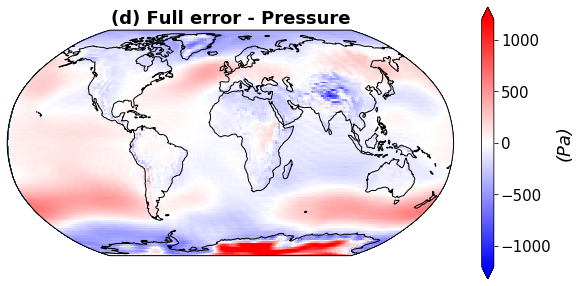

In [15]:
dataset = diff_p1
var = dataset[:]
palette = "bwr"
xmin = -1200
xmax = 1200
label = '(Pa)'
title = '(d) Full error - '+TITLE
name_fig = 'Fig4_full_error_'+variable+'.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)


# EOF + parametric component

## EOF

In [16]:
n=len(nb_p_list)
amip_list=[0]*(n+1)

amip_list[0] = amip['p1']

i = 0
while i<n:
    nb_p = nb_p_list[i]
    #print(nb_p)
    tmp = amip[str(nb_p)]
    amip_list[i+1] = tmp
    i+=1

In [17]:
matrix = xr.combine_nested(amip_list, concat_dim=['time'])

In [18]:
# Compute anomalies by removing the ensemble-mean.
mean = matrix.mean(axis=0)
anom = matrix - mean

In [19]:
# Create an EOF solver to do the EOF analysis. 
solver = Eof(anom, center=False)

In [20]:
varFrac = solver.varianceFraction(neigs=100)

## Get the observations

In [21]:
Mean =  pd.read_pickle(path_files+'npy/CNRMppe_decomposition_mean_'+str(variable)+'.npy').to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})
X_obs = obs[variable] - Mean
#X_obs = obs.expand_dims(dim={'dummy':range(0,102,1)})
#X_obs = obs.fillna(0.0)
X_obs

<xarray.DataArray (lat: 128, lon: 256)>
array([[ 594.96875,  606.2969 ,  617.4297 , ...,  557.35156,  570.39844,
         582.78125],
       [ 881.8047 ,  907.8047 ,  933.3672 , ...,  795.46094,  825.40625,
         853.8281 ],
       [ 904.2656 ,  925.8203 ,  946.4531 , ...,  859.6875 ,  849.4297 ,
         877.53125],
       ...,
       [-452.4297 , -454.1328 , -455.85938, ..., -452.75   , -449.33594,
        -450.8672 ],
       [-423.90625, -423.1797 , -422.46875, ..., -426.2578 , -425.46094,
        -424.6797 ],
       [-476.5625 , -476.2422 , -475.9375 , ..., -477.58594, -477.2422 ,
        -476.89844]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    mode     <U7 'pslmean'

In [22]:
neofs = 5
U_obs = solver.projectField(X_obs, neofs=neofs, weighted=False, eofscaling=0)
#U_obs = U_obs[0:4]
U_obs

<xarray.DataArray 'pseudo_pcs' (mode: 5)>
array([ 17916.693,  10520.148,  22854.988, -17135.393,  -9038.122],
      dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2 3 4
Attributes:
    long_name:  None_pseudo_pcs

### Save U_obs

In [23]:
np.save(path_files+'npy/CNRMppe_decomposition_U_obs_'+str(variables[0])+'.npy', U_obs)

## Compute error (parametric component)

In [35]:
def Error_rj_p1(pc_p1, U_obs, variable):
    rj_list = []
    for i in range(0,len(U_obs),1) :
        diff = (U_obs[i]-pc_p1[i])
        rj_list.append(diff)
    return rj_list

In [36]:
pc = solver.pcs(npcs=5, pcscaling=0)
pc_p1 = pc[0]

In [37]:
pseudo_pc_p1 = Error_rj_p1(pc_p1, U_obs, variable)
pseudo_pc_p1

[<xarray.DataArray ()>
 array(6516.2, dtype=float32)
 Coordinates:
     mode     int64 0
     time     int64 0, <xarray.DataArray ()>
 array(10765.078, dtype=float32)
 Coordinates:
     mode     int64 1
     time     int64 0, <xarray.DataArray ()>
 array(20992.95, dtype=float32)
 Coordinates:
     mode     int64 2
     time     int64 0, <xarray.DataArray ()>
 array(-11325.715, dtype=float32)
 Coordinates:
     mode     int64 3
     time     int64 0, <xarray.DataArray ()>
 array(-8183.921, dtype=float32)
 Coordinates:
     mode     int64 4
     time     int64 0]

## Reconstruct data 

In [38]:
eof = solver.eofs(neofs=5)
pc = solver.pcs(npcs=5, pcscaling=0)

In [39]:
rj_p1 = np.dot(pseudo_pc_p1[:], eof.transpose('lat', 'mode', 'lon'))

In [40]:
lat = diff_p1['lat']
lon = diff_p1['lon']

ds_rj_p1 = xr.DataArray(rj_p1, dims = ['lat', 'lon'], coords = [lat, lon]).to_dataset(name = 'tas')
ds_rj_p1

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 256)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    tas      (lat, lon) float32 141.13466 141.13466 ... -353.13693 -353.13693

## Plot error (parametric component)

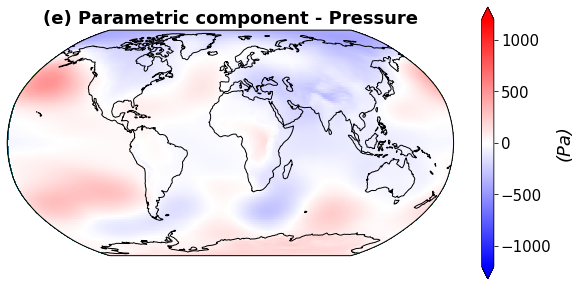

In [42]:
dataset = ds_rj_p1
var = dataset['tas']
palette = "bwr"
xmin = -1200
xmax = 1200
label = '(Pa)'
title = '(e) Parametric component - '+TITLE
name_fig = 'Fig4_param_error_'+variable+'.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)

# Non - parametric component

In [43]:
sj = diff_p1 - ds_rj_p1
sj

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 256)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    height   float64 ...
Data variables:
    tas      (lat, lon) float32 dask.array<chunksize=(128, 256), meta=np.ndarray>

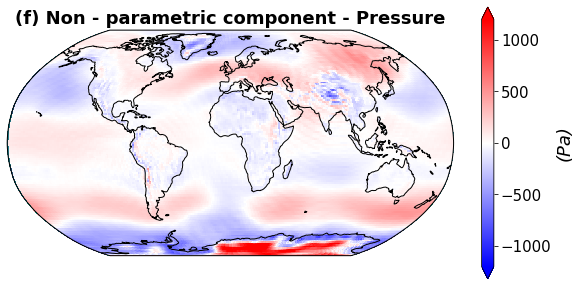

In [44]:
dataset = sj
var = dataset['tas']
palette = "bwr"
xmin = -1200
xmax = 1200
label = '(Pa)'
title = '(f) Non - parametric component - '+TITLE
name_fig = 'Fig4_sj_error_'+variable+'.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, name_fig)